In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
plt.style.use('ggplot')
import re
import sys
import skgstat as skg
import pandas as pd
from skgstat import OrdinaryKriging


In [33]:
%cd /home/andrew/Documents/git/dcgr_simulation/dcgr_simulation/rssi/

/home/andrew/Documents/git/dcgr_simulation/dcgr_simulation/rssi


In [34]:
with open('Parsed_3_10.csv', newline='') as csvfile:
  esp32 = pd.read_csv(csvfile)

esp32.head() 

,real_timestamp,rssi,x,y,imaginary,real,amplitude,phase
0,606.102,-52,2.655008,6.151083,"[-108, 8, 24, 24, 24, 22, 23, 24, 23, 25, 25, ...","[-64, 0, -10, -7, 0, 7, 8, 8, 11, 10, 10, 6, 1...","[125.53883861180172, 8.0, 26.0, 25.0, 24.0, 23...","[-2.105751400580993, 1.5707963267948966, 1.965..."
1,606.108,-52,2.645286,6.168444,"[-108, 8, 12, 9, 2, -5, -5, -5, -8, -7, -8, -4...","[-64, 0, 22, 23, 24, 22, 24, 25, 24, 25, 26, 2...","[125.53883861180172, 8.0, 25.059928172283335, ...","[-2.105751400580993, 1.5707963267948966, 0.499..."
2,606.114,-52,2.656568,6.155088,"[-108, 8, -21, -22, -22, -21, -22, -23, -22, -...","[-64, 0, 10, 8, 2, -4, -4, -5, -8, -7, -7, -2,...","[125.53883861180172, 8.0, 23.259406699226016, ...","[-2.105751400580993, 1.5707963267948966, -1.12..."
3,606.120,-52,2.643135,6.141601,"[-108, 8, -13, -9, -2, 4, 5, 5, 9, 8, 9, 4, 7,...","[-64, 0, -23, -24, -25, -23, -24, -25, -25, -2...","[125.53883861180172, 8.0, 26.419689627245813, ...","[-2.105751400580993, 1.5707963267948966, -2.62..."
4,609.105,-52,2.639002,6.157158,"[-108, 8, 15, 12, 6, 0, 1, -1, -2, -2, -2, 3, ...","[-64, 0, 19, 20, 21, 22, 24, 24, 25, 25, 26, 2...","[125.53883861180172, 8.0, 24.20743687382041, 2...","[-2.105751400580993, 1.5707963267948966, 0.668..."


In [35]:
x = esp32['x'].to_numpy()
y = esp32['y'].to_numpy()
rssi = esp32['rssi'].to_numpy()
im = esp32['imaginary'].to_numpy()
real = esp32['real'].to_numpy()
amp = esp32['amplitude'].to_numpy()
ph = esp32['phase'].to_numpy()

In [6]:
# store all length-64 arrays of amplitude (magnitude) data into one big array
# create arrays for avg and max amplitude (magnitude) for each timestamp
rawAmp = np.zeros(amp.shape[0], dtype='object')
ampAvg = np.zeros(amp.shape[0])
ampMax = np.zeros(amp.shape[0])
for i in range(amp.shape[0]):
    current = amp[i]
    if (current == '[]'):
        rawAmp[i] = -1
        ampAvg[i] = -1
        ampMax[i] = -1 
    else:
        current = current[1:]
        current = current[:-1]
        ampArr = np.array([float(x) for x in current.split(", ") if x != ''])
        rawAmp[i] = ampArr
        ampAvg[i] = np.average(ampArr)
        ampMax[i] = np.max(ampArr)

# store all length-64 arrays of phase data into one big array
# create arrays for avg and max phase for each timestamp
rawPh = np.zeros(ph.shape[0], dtype='object')
phAvg = np.zeros(ph.shape[0])
phMax = np.zeros(ph.shape[0])
for i in range(ph.shape[0]):
    current = ph[i]
    if (current == '[]'):
        rawPh[i] = -1
        phAvg[i] = -1
        phMax[i] = -1 
    else:
        current = current[1:]
        current = current[:-1]
        phArr = np.array([float(x) for x in current.split(", ") if x != ''])
        rawPh[i] = phArr
        phAvg[i] = np.average(phArr)
        phMax[i] = np.max(phArr)

In [7]:
# store all length-64 arrays of real components of the data into one big array
# create arrays for avg and max real component for each timestamp
rawReal = np.zeros(real.shape[0], dtype='object')
realAvg = np.zeros(real.shape[0])
realMax = np.zeros(real.shape[0])
for i in range(real.shape[0]):
    current = real[i]
    if (current == '[]'):
        rawReal[i] = -1
        realAvg[i] = -1
        realMax[i] = -1 
    else:
        current = current[1:]
        current = current[:-1]
        realArr = np.array([float(x) for x in current.split(", ") if x != ''])
        rawReal[i] = realArr
        realAvg[i] = np.average(realArr)
        realMax[i] = np.max(realArr)
        
# store all length-64 arrays of imaginary components of the data into one big array
# create arrays for avg and max imaginary component for each timestamp
rawIm = np.zeros(im.shape[0], dtype='object')
imAvg = np.zeros(im.shape[0])
imMax = np.zeros(im.shape[0])
for i in range(im.shape[0]):
    current = im[i]
    if (current == '[]'):
        rawIm[i] = -1
        imAvg[i] = -1
        imMax[i] = -1 
    else:
        current = current[1:]
        current = current[:-1]
        imArr = np.array([float(x) for x in current.split(", ") if x != ''])
        rawIm[i] = imArr
        imAvg[i] = np.average(imArr)
        imMax[i] = np.max(imArr)

In [8]:
# create RGB values for each x/y position based on the rssi for that timestamp 
# cyan = no data taken at this position
# green = best
# yellow = good
# orange = mid
# red = worst

R = np.zeros(rssi.shape[0])
G = np.zeros(rssi.shape[0])
B = np.zeros(rssi.shape[0])

# create RGB values
for i in range(rssi.shape[0]):
    if (ampAvg[i] == -1):
        R[i] = 0
        G[i] = 255
        B[i] = 255
    elif (rssi[i] >= -50):
        R[i] = 0
        G[i] = 255
        B[i] = 0
    elif (rssi[i] >= -60):
        R[i] = 255
        G[i] = 255
        B[i] = 0
    elif (rssi[i] >= -70):
        R[i] = 255
        G[i] = 255*0.75
        B[i] = 0
    else:
        R[i] = 255
        G[i] = 0
        B[i] = 0

In [9]:
# borrowed code for reading a pgm file into numpy array
np.set_printoptions(threshold=sys.maxsize)

# https://stackoverflow.com/questions/7368739/numpy-and-16-bit-pgm
def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))
    
    
  

In [10]:
pic=read_pgm(r'small_basement.pgm')
pic2=np.copy(pic)
a=np.array(3)
pic2 = np.dstack([pic2, pic2, pic2])

In [11]:
# scale x/y values to fit basement map
scale=0.01999999999
scale=(1.0/float(scale))
x1=x*scale
y1=np.absolute(y*scale)

In [12]:
# create dots on basement map using RGB values and x/y coords
for i in range(ampAvg.shape[0]):
    pic2[1236-int(y1[i])-5:1236-int(y1[i])+5,int(x1[i])-5:int(x1[i])+5:,:]= [R[i], G[i], B[i]]

# location of router (magenta)
pic2[675-5:675+5, 1140-5:1140+5] = [255, 0, 255]

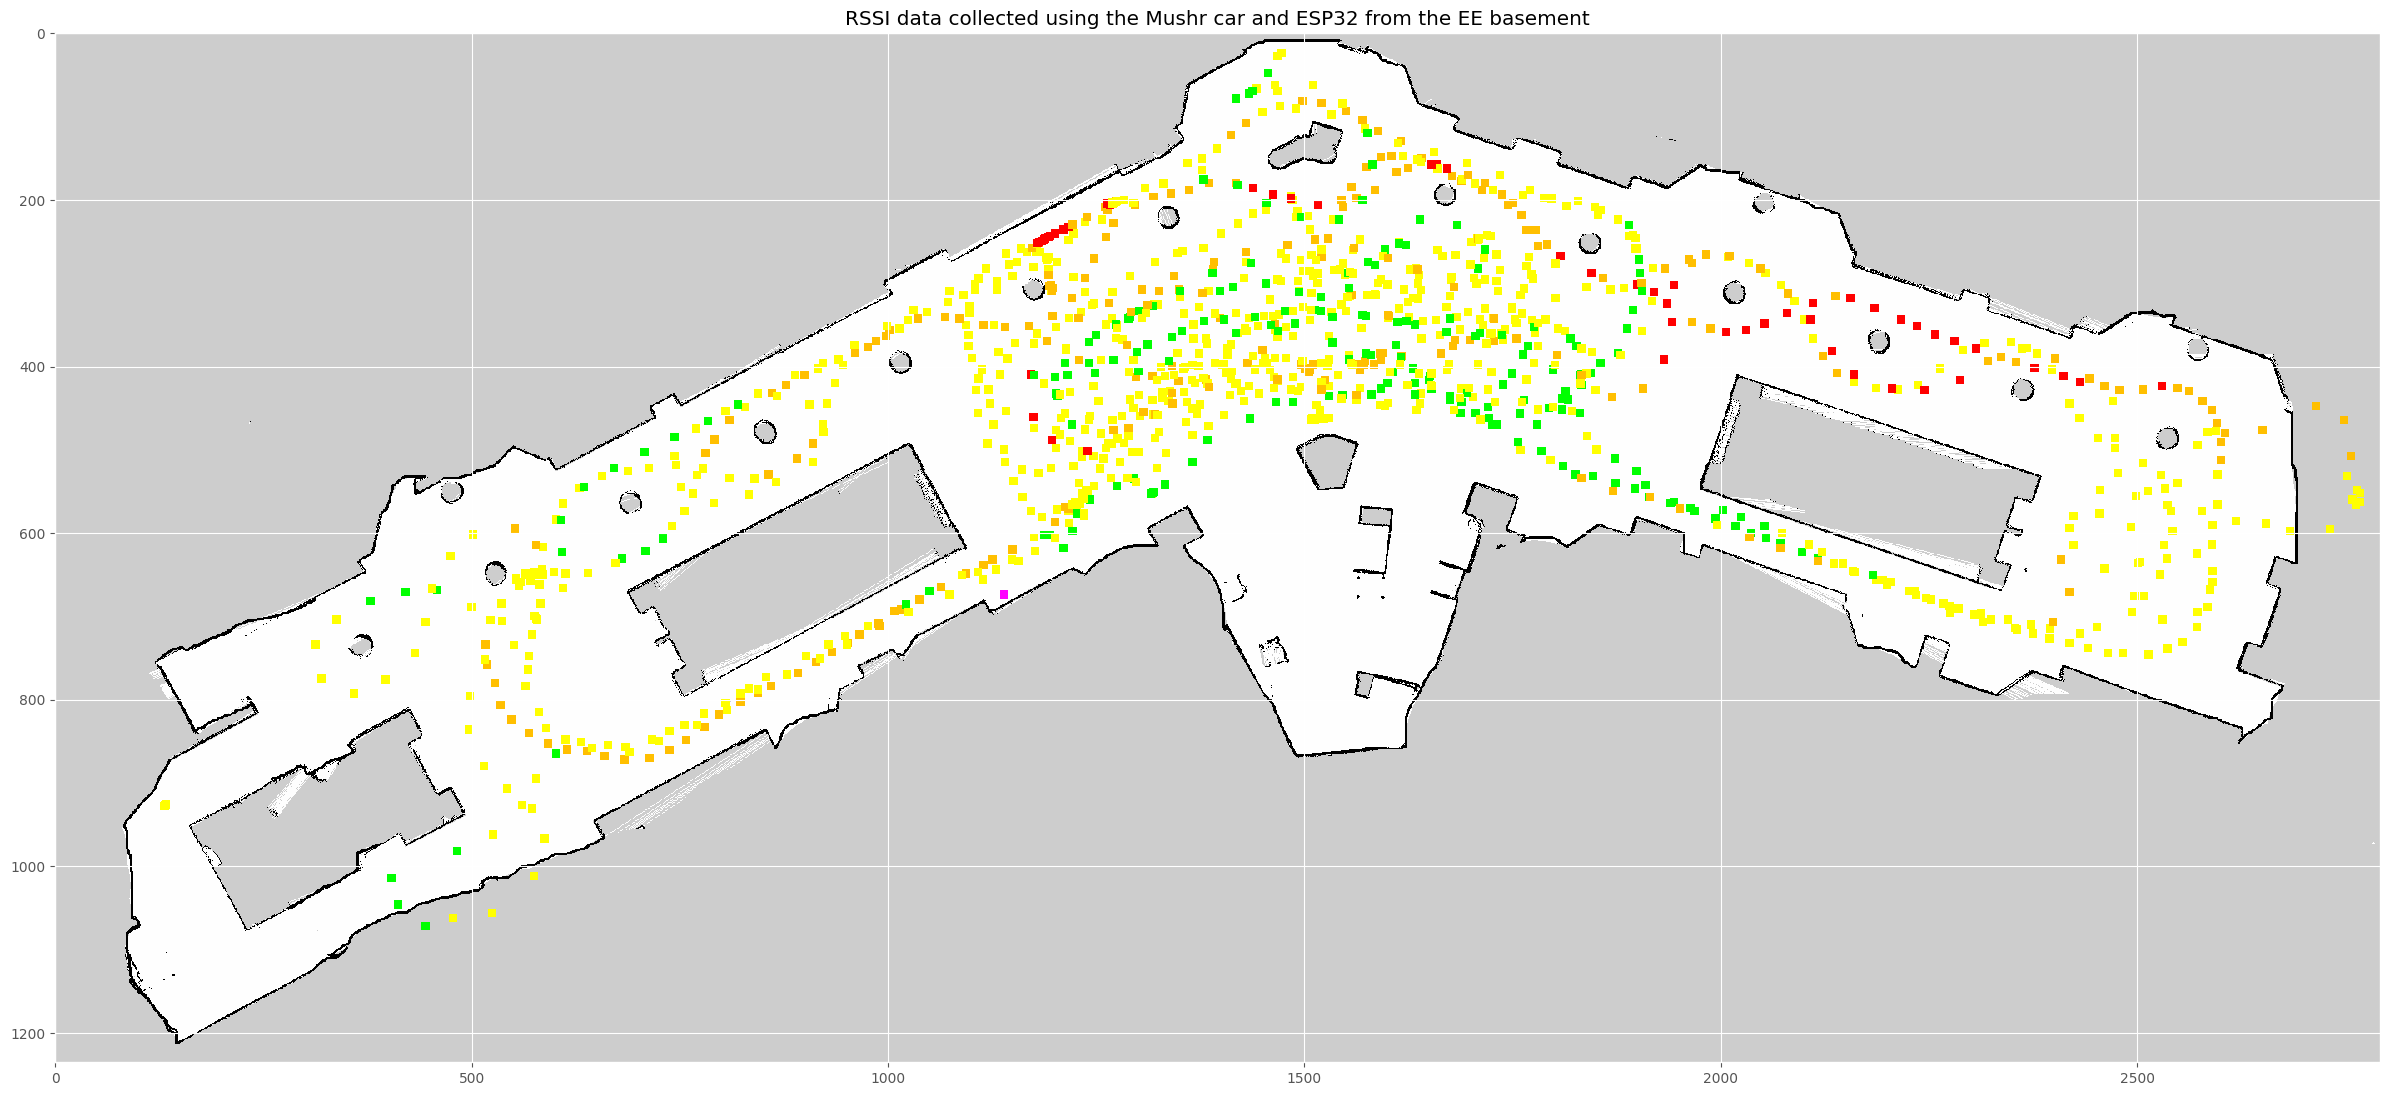

In [41]:
# plot color-coded map
plt.subplots(1, figsize=(30, 20))

#plt.pcolor(pic2, cmap=plt.cm.inferno)
plt.imshow(pic2,interpolation='nearest' )
plt.title('EE Basement RSSI data collected using ESP32 and UW MuSHr Car')
plt.show()

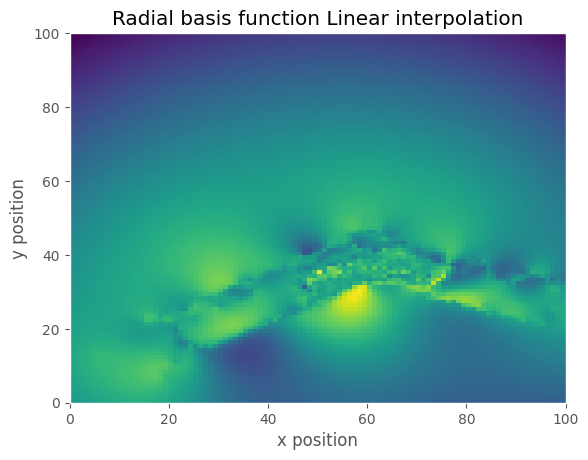

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import Rbf  # radial basis functions

rbf_function = Rbf(x, y, rssi, function='linear')
x_new = np.arange(0, 50, 0.5)
y_new = np.arange(0, 50, 0.5)

x_grid, y_grid = np.meshgrid(x_new, y_new)

z_new = rbf_function(x_grid.ravel(), y_grid.ravel()).reshape(x_grid.shape)

#z_new[31,57]=200
plt.pcolor(z_new)
#look at the original map scaled
#plt.plot(x, y, 'r')
plt.xlabel('x'); plt.ylabel('y')
plt.title('Radial basis function Linear interpolation')
plt.xlabel('x position')
plt.ylabel('y position') 
plt.show()

In [15]:
z_new[31,57]=200

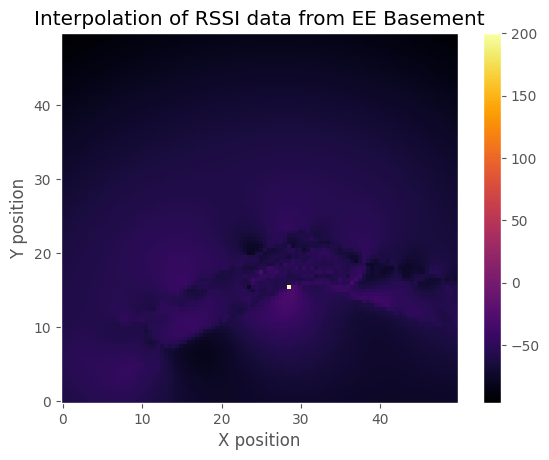

In [16]:
plt.pcolor(x_new, y_new, z_new, cmap=plt.cm.inferno)

plt.xlabel('X position')
plt.ylabel('Y position') 
plt.title('Interpolation of RSSI data from EE Basement')

plt.colorbar()

In [17]:
np.save('rssi_experiment.npy',z_new)

In [18]:
np.where(z_new==np.min(z_new))

(array([99]), array([0]))

In [19]:
g= np.where(z_new==-31.41777097)

In [20]:
print(g)

(array([], dtype=int64), array([], dtype=int64))


In [21]:
z_new[27,57]

-32.21255049565298

In [22]:
print(np.shape(z_new))

(100, 100)


In [23]:
%cd

/home/andrew


In [24]:
rssi_basement = np.load('/home/andrew/Documents/git/dcgr_simulation/dcgr_simulation/rssi/rssi_history.npy')
rssi_simulated = np.load('/home/andrew/Documents/git/dcgr_simulation/dcgr_simulation/rssi/rssi_history1.npy')

In [25]:
len(rssi_simulated[:50])

50

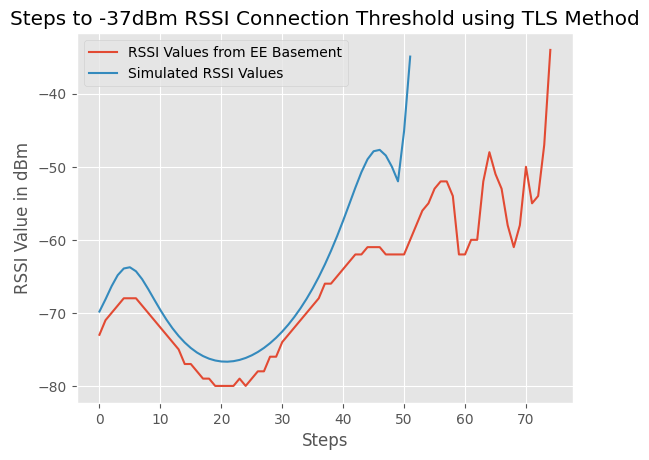

In [26]:
plt.plot(rssi_basement, label='RSSI Values from EE Basement')
plt.plot(rssi_simulated[0:52], label='Simulated RSSI Values')
plt.xlabel('Steps')
plt.ylabel('RSSI Value in dBm')
plt.title('Steps to -37dBm RSSI Connection Threshold using TLS Method')
plt.legend()

plt.savefig('rssi_steps_comparison')
plt.show()

